<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/Handwriting_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Augmentations

The following notebook contains possible augmentations for handwriting
recognition to preserve sequential information while increasing variety
in handwriting style and examples.

Types of Augmentation:
* Add Noise
* Random Strokes
* Bleedthrough
* Sharpen
* Blur
* Vertical Crop
* Light Affine Transformations
  * Sheer
  * Slight Rotation
* Random Grid Warp Distortions

## Download the Dataset

We will use samples from the IAM dataset to perform augmentations.

In [1]:
# IAM HWR WORD LEVEL DATSET
# ID: 1WRsxO6I2nwB64I4tTy0gHbht1wgGW1QQ
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WRsxO6I2nwB64I4tTy0gHbht1wgGW1QQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WRsxO6I2nwB64I4tTy0gHbht1wgGW1QQ" -O iam_hwr_word_level.zip && rm -rf /tmp/cookies.txt
!unzip -q iam_hwr_word_level.zip
!rm iam_hwr_word_level.zip

!rm -r __MACOSX

## Dependencies

Install *tensorflow-addons* and import necessary dependencies.

In [1]:
!pip install tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Load an Image

Load an image using pillow and convert to a tensorflow image to be stored in the
*img* variable.

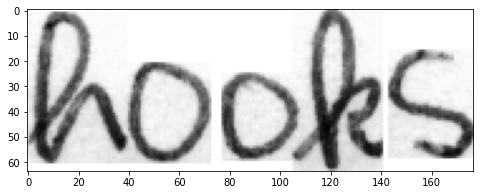

In [3]:
pil_image = Image.open('iam_hwr_word_level/images/e01-102-07-01.png')
np_image = np.array(pil_image)
img = tf.constant(np_image, dtype=tf.float32)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.pause(0.01)

## Display Function

A handy function for displaying images before and after the augmentation.

In [4]:
def display_augmentation(func, *params):
    plt.figure(figsize=(8,8))
    plt.title('Original Image')
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.pause(0.01)

    after_img = func(*params)
    
    plt.figure(figsize=(8,8))
    plt.title('Augmented Image')
    plt.imshow(tf.squeeze(after_img), cmap='gray')
    plt.pause(0.01)

## Resize Function

For resizing and padding images to be the same shape.

In [5]:
def img_resize_with_pad(img_tensor, desired_size, pad_value=255):
    img_size = tf.shape(img_tensor)

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
        # Solve by height
        new_height = desired_size[0]
        new_width = int(desired_size[0] // img_ratio)
    else:
        new_height = int(desired_size[1] * img_ratio)
        new_width = desired_size[1]
        # Solve by width

    resized_img = tf.image.resize(img_tensor, (new_height, new_width), method=tf.image.ResizeMethod.BICUBIC)

    pad_height = desired_size[0] - new_height
    pad_width = desired_size[1] - new_width

    img_padded = tf.pad(resized_img, [[pad_height, 0], [0, pad_width], [0, 0]], constant_values=pad_value)

    return img_padded

## Noise Augmentation

Add random noise from a gaussian to be added to the image with mean=0 and the
std being uniformly sampled between 0.0 and 2.0

In [6]:
def noise_augmentation(img):
    img_shape = tf.shape(img)
    std = tf.math.reduce_std(img) * tf.random.uniform((), minval=0.0, maxval=2.0, dtype=tf.float32)
    noise = tf.random.normal(img_shape, mean=0.0, stddev=std)

    return tf.math.add(img, noise)

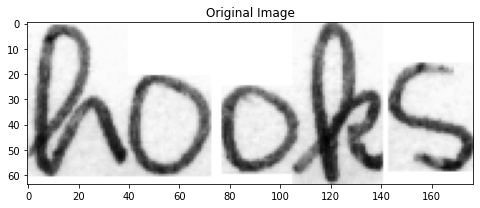

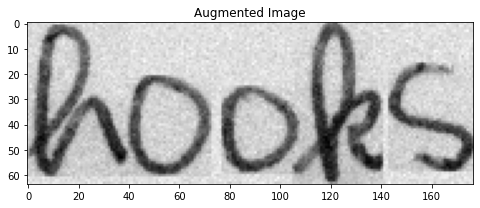

In [7]:
display_augmentation(noise_augmentation, img)

## Random Strokes

Add random strokes above or below the image. This is to simulate poor
segmentations where the ascenders or descenders of the above or below line
creeps into the current word snippet.

For this augmentation, we can simply translate and overlay another image on top
of the original.

In [8]:
def random_strokes_augmentation(img, other_img, fill_value=255):
    if tf.random.uniform((), maxval=2, dtype=tf.int32):
        translation_amount = -(.8 * tf.cast(tf.shape(img)[0], dtype=tf.float32))
    else:
        translation_amount = (.6 * tf.cast(tf.shape(img)[0], dtype=tf.float32))

    strokes = tfa.image.translate(other_img, [0, translation_amount], fill_value=fill_value)

    return tf.minimum(img, strokes)

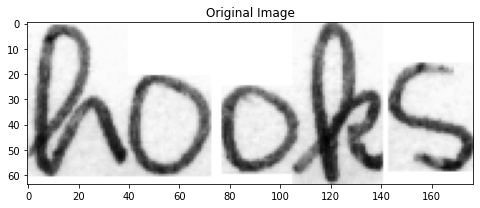

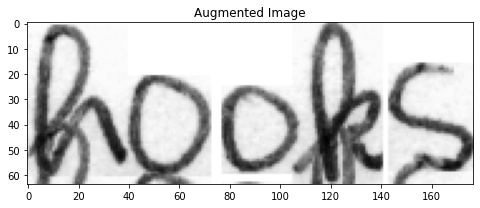

In [9]:
other_img = tf.constant(np.array(Image.open('iam_hwr_word_level/images/e01-102-07-01.png')), dtype=tf.float32)
other_img = tf.squeeze(img_resize_with_pad(tf.expand_dims(other_img, 2), img.shape))

display_augmentation(random_strokes_augmentation, img, other_img)

## Bleedthrough

Overlay a lightened reversed word on top of the original image. This is to
simulate ink bleeding through from the writing on the opposite side of the
paper, which is fairly common in historical documents.

This augmentation will apply overlay the image with a random translation and
transparency. Some of the produced images will be more severe than others.

In [10]:
def reverse_and_lighten(img, fill_value=255):
    img = tf.reverse(img, [0])  # reverse on x dimension
    img = img - fill_value  # shift so that 0 is white, black negative
    bleedthrough_value = tf.random.uniform((), minval=0.2, maxval=0.7)
    img = tf.math.scalar_mul(bleedthrough_value, img)  # scale towards 0 to make it less
    img = img + fill_value  # shift so that 0 is white, black negative
    return img

def bleedthrough_augmentation(img, other_img1, other_img2):
    height = tf.shape(img)[0]

    other_img = tf.concat((other_img1, other_img2), axis=0)
    other_img = reverse_and_lighten(other_img)
    other_img = tf.roll(other_img, tf.random.uniform((), maxval=height, dtype=tf.int32), axis=0)
    other_img = other_img[0:height]

    return tf.minimum(img, other_img)

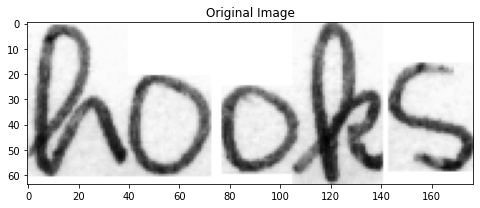

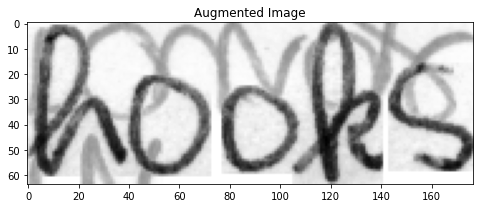

In [11]:
other_img = tf.constant(np.array(Image.open('iam_hwr_word_level/images/e01-102-07-02.png')), dtype=tf.float32)
other_img = tf.squeeze(img_resize_with_pad(tf.expand_dims(other_img, 2), img.shape))

other_img2 = tf.constant(np.array(Image.open('iam_hwr_word_level/images/e01-102-07-03.png')), dtype=tf.float32)
other_img2 = tf.squeeze(img_resize_with_pad(tf.expand_dims(other_img2, 2), img.shape))

display_augmentation(bleedthrough_augmentation, img, other_img, other_img2)

## Sharpen

Sharpen the image with a factor between 0.0 and 0.3. Then blend the iamge with
an alpha between 0.0 and 0.5.

In [12]:
def sharpen_augmentation(img):
    factor = tf.random.uniform((), minval=0, maxval=0.3, dtype=tf.float32)
    alpha = tf.random.uniform((), minval=0.0, maxval=0.5)
    return (img + tfa.image.sharpness(img, 1/factor)) * alpha

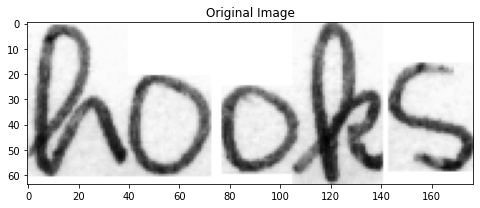

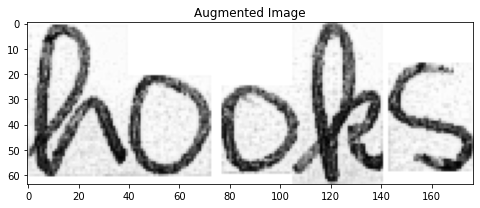

In [13]:
display_augmentation(sharpen_augmentation, img)

## Blur

Blur the image by sending it through a 3x3 gaussian filter with a
std deviation of 0.5 or 1.0.

In [14]:
def blur_augmentation(img):
    if tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32):
        sigma = 0.5
    else:
        sigma = 1.0
    
    return tfa.image.gaussian_filter2d(img, (3, 3), sigma=sigma)

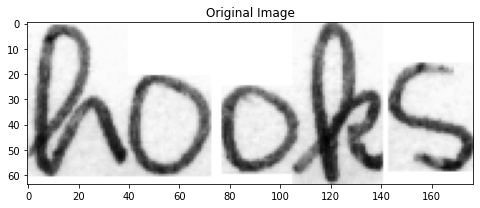

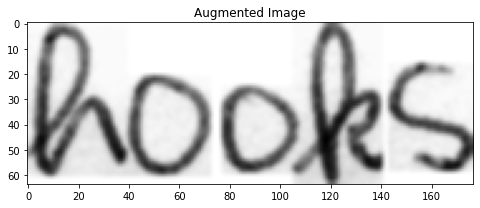

In [17]:
display_augmentation(blur_augmentation, img)

## Vertical Crop

Crop the image only vertically, to preserve all characters and the proper
sequence (width remains the same). We determine the size of the crop height by
uniformly sampling between 0.6 and 0.95 of the image height.

The image is then resized back to the original shape and translated up or
down a random amount.

In [18]:
def vertical_crop_augmentation(img):
    img_height = tf.cast(tf.shape(img)[0], tf.float32)
    cropped_height = tf.random.uniform((), minval=0.6, maxval=0.95) * img_height
    
    crop = tf.image.random_crop(img, [cropped_height, 177])
    resized_crop = tf.squeeze(img_resize_with_pad(tf.expand_dims(crop, 2), img.shape))

    translation_dist = -tf.random.uniform((), minval=0, maxval=img_height-cropped_height)
    trans_resized_crop = tfa.image.translate(resized_crop, translations=[0, translation_dist], fill_value=255)

    return trans_resized_crop

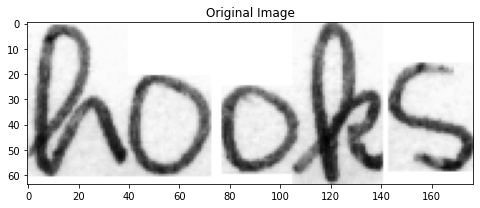

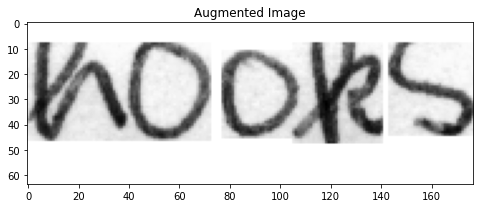

In [19]:
display_augmentation(vertical_crop_augmentation, img)

## Affine Transformation - Rotation

Rotate the image between -12 and 12 degrees. Severe rotations do not preserve
the sequential nature of the characters, so uniformly sampling within this
range seems appropriate.

In [20]:
def rotate(img, fill_value=255, minangle=-12, maxangle=12):
    radians = tf.random.uniform((), minval=minangle, maxval=maxangle) * 3.14159 / 180.
    return tfa.image.rotate(img, radians, fill_value=255)

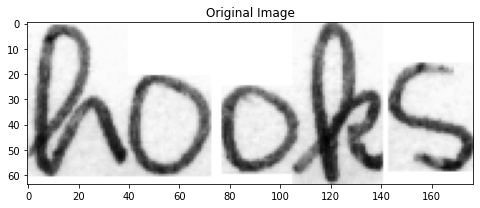

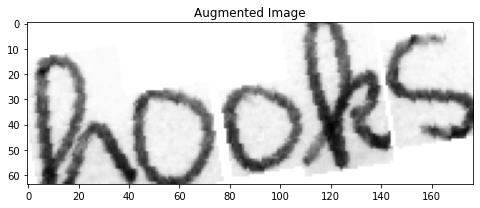

In [24]:
display_augmentation(rotate, img)

## Affine Transformation - Shear

Shear the image along the x-axis which using a shear level between
-0.25 and 0.25. Severe shearing can often cut off characters, so this
range seems appropriate.

In [25]:
def shear(img, fill_value=255, level=0.25):
    img = tf.image.grayscale_to_rgb(tf.expand_dims(img, 2))
    shear_level = tf.random.uniform((), minval=-level, maxval=level)
    sheared = tfa.image.shear_x(img, shear_level, replace=fill_value) 

    return tf.squeeze(tf.image.rgb_to_grayscale(sheared))

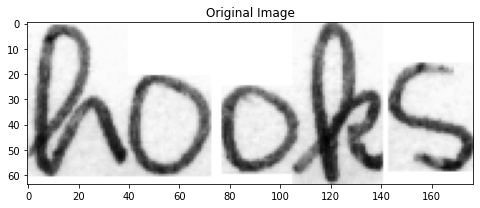

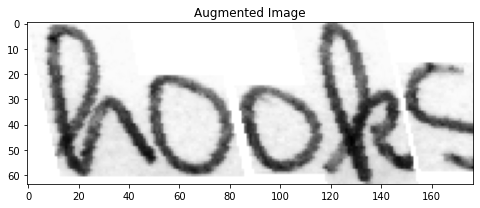

In [27]:
display_augmentation(shear, img, 255, 0.25)

## Random Grid Warp Distortion

Random grid warp distortions are explained in the following paper:

[Data Augmentation for Recognition of Handwritten
Words and Lines using a CNN-LSTM Network](https://ieeexplore.ieee.org/abstract/document/8270041)

Essentially, we overlay a grid on top of the image and randomly warp the
points on the grid where lines intersect (control points). We can control the
augmentation by modifying the grid interval and standard deviation.

In [28]:
def batch_random_grid_warp_distortions(batch, grid_interval=16, stddev=2.0):
    batch_shape = tf.shape(batch)

    # Create grid of control points based on height, width, and grid interval
    row_list = tf.range(0, batch_shape[1], delta=grid_interval, dtype=tf.float32)
    column_list = tf.range(0, batch_shape[2], delta=grid_interval, dtype=tf.float32)
    control_points = tf.transpose([tf.tile(row_list, tf.shape(column_list)), tf.repeat(column_list, len(row_list))])

    # Sample from normal distribution with mean 0 and stddev as given by parameter
    random_distortions = tf.random.normal((batch_shape[0], tf.shape(control_points)[0], tf.shape(control_points)[1]),
                                          mean=0, stddev=stddev)

    # Apply the distortion - with broadcasting
    destination_points = control_points + random_distortions

    # Tensorflow add-ons uses non-tf functions to perform this operation
    warped_batch, _ = tf.py_function(tfa.image.sparse_image_warp, [batch, control_points, destination_points],
                                     [tf.float32, tf.float32])

    return warped_batch

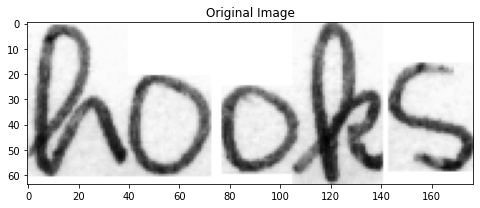

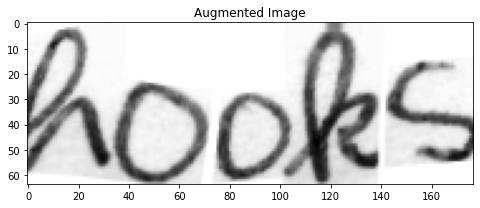

In [41]:
interval = 32
stddev = 3
display_augmentation(batch_random_grid_warp_distortions, tf.expand_dims(tf.expand_dims(img, 0), 3), interval, stddev)